Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBClassifier
from scipy import stats
import shap
import joblib


 Load Dataset and Preprocess Data

In [2]:
# Load the dataset
file_path = 'survey lung cancer.csv'  # Update the path if needed
data = pd.read_csv(file_path)

# Clean target labels: Remove any trailing whitespace or tabs
data['LUNG_CANCER'] = data['LUNG_CANCER'].str.strip()

# Convert target labels to binary (1 for 'ckd', 0 for 'notckd')
data['LUNG_CANCER'] = data['LUNG_CANCER'].replace({'YES': 1, 'NO': 0})

data['GENDER'] = data['GENDER'].replace({'M': 1, 'F': 0})

# Split features (X) and target (y)
X = data.drop(columns=[ 'LUNG_CANCER'])  # Drop 'id' and target column
y = data['LUNG_CANCER']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

data.head(5)   

C:\Users\MARWAN\AppData\Local\Temp\ipykernel_15924\2752143435.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['LUNG_CANCER'] = data['LUNG_CANCER'].replace({'YES': 1, 'NO': 0})
C:\Users\MARWAN\AppData\Local\Temp\ipykernel_15924\2752143435.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['GENDER'] = data['GENDER'].replace({'M': 1, 'F': 0})


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,0,59,1,1,1,2,1,2,1,2,1,2,2,1,2,0
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,0
4,0,63,1,2,1,1,1,1,1,2,1,2,2,1,1,0


Define Preprocessing Pipelines

In [3]:
  # Numeric feature preprocessing with more robust handling
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Median imputation for missing values
        ('scaler', StandardScaler()),  # Standardize features
        ('outlier_detection', RobustScaler())  # Additional outlier handling
    ])
    
    # Categorical feature preprocessing with advanced encoding
categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Most frequent value imputation
        ('onehot', OneHotEncoder(
            handle_unknown='ignore',  # Handle unknown categories
            sparse_output=False,  # Return dense array
            drop='first'  # Reduce multicollinearity by dropping first category
        ))
    ])
    
    # Combine preprocessing steps
preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'  # Drop any columns not specified
    )

Define Models and Search Spaces

In [4]:
# Define a dictionary of models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Define search spaces for hyperparameter optimization
search_spaces = {
    "Random Forest": {'n_estimators': Integer(50, 200), 'max_depth': Integer(5, 50), 'min_samples_split': Integer(2, 10)},
    "Gradient Boosting": {'n_estimators': Integer(50, 200), 'learning_rate': Real(0.01, 0.2), 'max_depth': Integer(3, 10)},
    "AdaBoost": {'n_estimators': Integer(50, 200), 'learning_rate': Real(0.01, 2)},
    "Support Vector Machine": {'C': Real(0.1, 10), 'gamma': Real(0.01, 1), 'kernel': ['rbf', 'linear']},
    "Logistic Regression": {'C': Real(0.01, 10), 'solver': ['lbfgs', 'liblinear']},
    "Decision Tree": {'max_depth': Integer(3, 10), 'min_samples_split': Integer(2, 10)},
    "Naive Bayes": {},  # No hyperparameters to tune
    "K-Nearest Neighbors": {'n_neighbors': Integer(3, 15), 'weights': ['uniform', 'distance']}
}



Feature Selection and Random State Loop

In [5]:
# Initialize results dictionary
all_results = {}

# Loop over different random states
random_states = [42]
for random_state in random_states:
    print(f"\nEvaluating models with random_state={random_state}...")
    results = {}

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=random_state, stratify=y, shuffle=True
    )

    # Preprocess data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Perform Feature Selection: SelectKBest
    k_best_selector = SelectKBest(score_func=f_classif, k=10)
    X_train_k_best = k_best_selector.fit_transform(X_train_preprocessed, y_train)
    X_test_k_best = k_best_selector.transform(X_test_preprocessed)

    # Perform Feature Selection: RFE
    rfe_selector = RFE(estimator=RandomForestClassifier(random_state=random_state), n_features_to_select=10)
    X_train_rfe = rfe_selector.fit_transform(X_train_preprocessed, y_train)
    X_test_rfe = rfe_selector.transform(X_test_preprocessed)

    # Evaluate models using both feature selection methods
    for method, (X_train_fs, X_test_fs) in {"SelectKBest": (X_train_k_best, X_test_k_best),
                                           "RFE": (X_train_rfe, X_test_rfe)}.items():
        print(f"\nUsing Feature Selection Method: {method}")
        optimized_models = {}

        # Hyperparameter optimization using BayesSearchCV
        for model_name, model in models.items():
            search_space = search_spaces[model_name]
            if not search_space:
                print(f"Skipping {model_name} (no hyperparameters to tune).")
                continue

            optimizer = BayesSearchCV(model, search_space, n_iter=20, cv=5, random_state=random_state, n_jobs=-1)
            optimizer.fit(X_train_fs, y_train)

            # Store the optimized model
            optimized_models[model_name] = optimizer
            print(f"Best parameters for {model_name}: {optimizer.best_params_}")

        # Evaluate each optimized model
        for model_name, optimizer in optimized_models.items():
            model = optimizer.best_estimator_
            y_pred = model.predict(X_test_fs)
            accuracy = accuracy_score(y_test, y_pred)
            results[(method, model_name)] = accuracy

    # Store results for current random state
    all_results[random_state] = results

# Create DataFrame for analysis
rows = []
for random_state in all_results:
    for (method, model_name), accuracy in all_results[random_state].items():
        rows.append({
            'Random State': random_state,
            'Feature Selection': method,
            'Model': model_name,
            'Accuracy': accuracy
        })

results_df = pd.DataFrame(rows)

# Calculate statistics
stats_df = results_df.groupby(['Model', 'Feature Selection'])['Accuracy'].agg(['mean', 'std']).round(4)
stats_pivot = stats_df.unstack()

# Calculate differences
rfe_results = stats_df.xs('RFE', level=1)
kbest_results = stats_df.xs('SelectKBest', level=1)
differences = (rfe_results - kbest_results).round(4)

# Perform t-tests
t_test_results = {}
for model in results_df['Model'].unique():
    rfe_scores = results_df[(results_df['Model'] == model) & 
                           (results_df['Feature Selection'] == 'RFE')]['Accuracy']
    kbest_scores = results_df[(results_df['Model'] == model) & 
                             (results_df['Feature Selection'] == 'SelectKBest')]['Accuracy']
    t_stat, p_value = stats.ttest_rel(rfe_scores, kbest_scores)
    t_test_results[model] = p_value




Evaluating models with random_state=42...

Using Feature Selection Method: SelectKBest
Best parameters for Random Forest: OrderedDict([('max_depth', 8), ('min_samples_split', 2), ('n_estimators', 51)])
Best parameters for Gradient Boosting: OrderedDict([('learning_rate', 0.08720389721924951), ('max_depth', 4), ('n_estimators', 166)])


c:\Users\MARWAN\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters for AdaBoost: OrderedDict([('learning_rate', 0.5481365153458676), ('n_estimators', 50)])
Best parameters for Support Vector Machine: OrderedDict([('C', 4.160029192647807), ('gamma', 0.7304484857455519), ('kernel', 'linear')])
Best parameters for Logistic Regression: OrderedDict([('C', 8.37550967197731), ('solver', 'liblinear')])
Best parameters for Decision Tree: OrderedDict([('max_depth', 6), ('min_samples_split', 8)])
Skipping Naive Bayes (no hyperparameters to tune).
Best parameters for K-Nearest Neighbors: OrderedDict([('n_neighbors', 10), ('weights', 'uniform')])

Using Feature Selection Method: RFE
Best parameters for Random Forest: OrderedDict([('max_depth', 42), ('min_samples_split', 3), ('n_estimators', 140)])
Best parameters for Gradient Boosting: OrderedDict([('learning_rate', 0.10924111464174323), ('max_depth', 4), ('n_estimators', 65)])


c:\Users\MARWAN\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters for AdaBoost: OrderedDict([('learning_rate', 0.32474161020200254), ('n_estimators', 50)])
Best parameters for Support Vector Machine: OrderedDict([('C', 9.995125405740207), ('gamma', 0.04507184107286535), ('kernel', 'rbf')])
Best parameters for Logistic Regression: OrderedDict([('C', 3.1712240163933676), ('solver', 'lbfgs')])
Best parameters for Decision Tree: OrderedDict([('max_depth', 3), ('min_samples_split', 9)])
Skipping Naive Bayes (no hyperparameters to tune).
Best parameters for K-Nearest Neighbors: OrderedDict([('n_neighbors', 6), ('weights', 'uniform')])


c:\Users\MARWAN\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\MARWAN\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


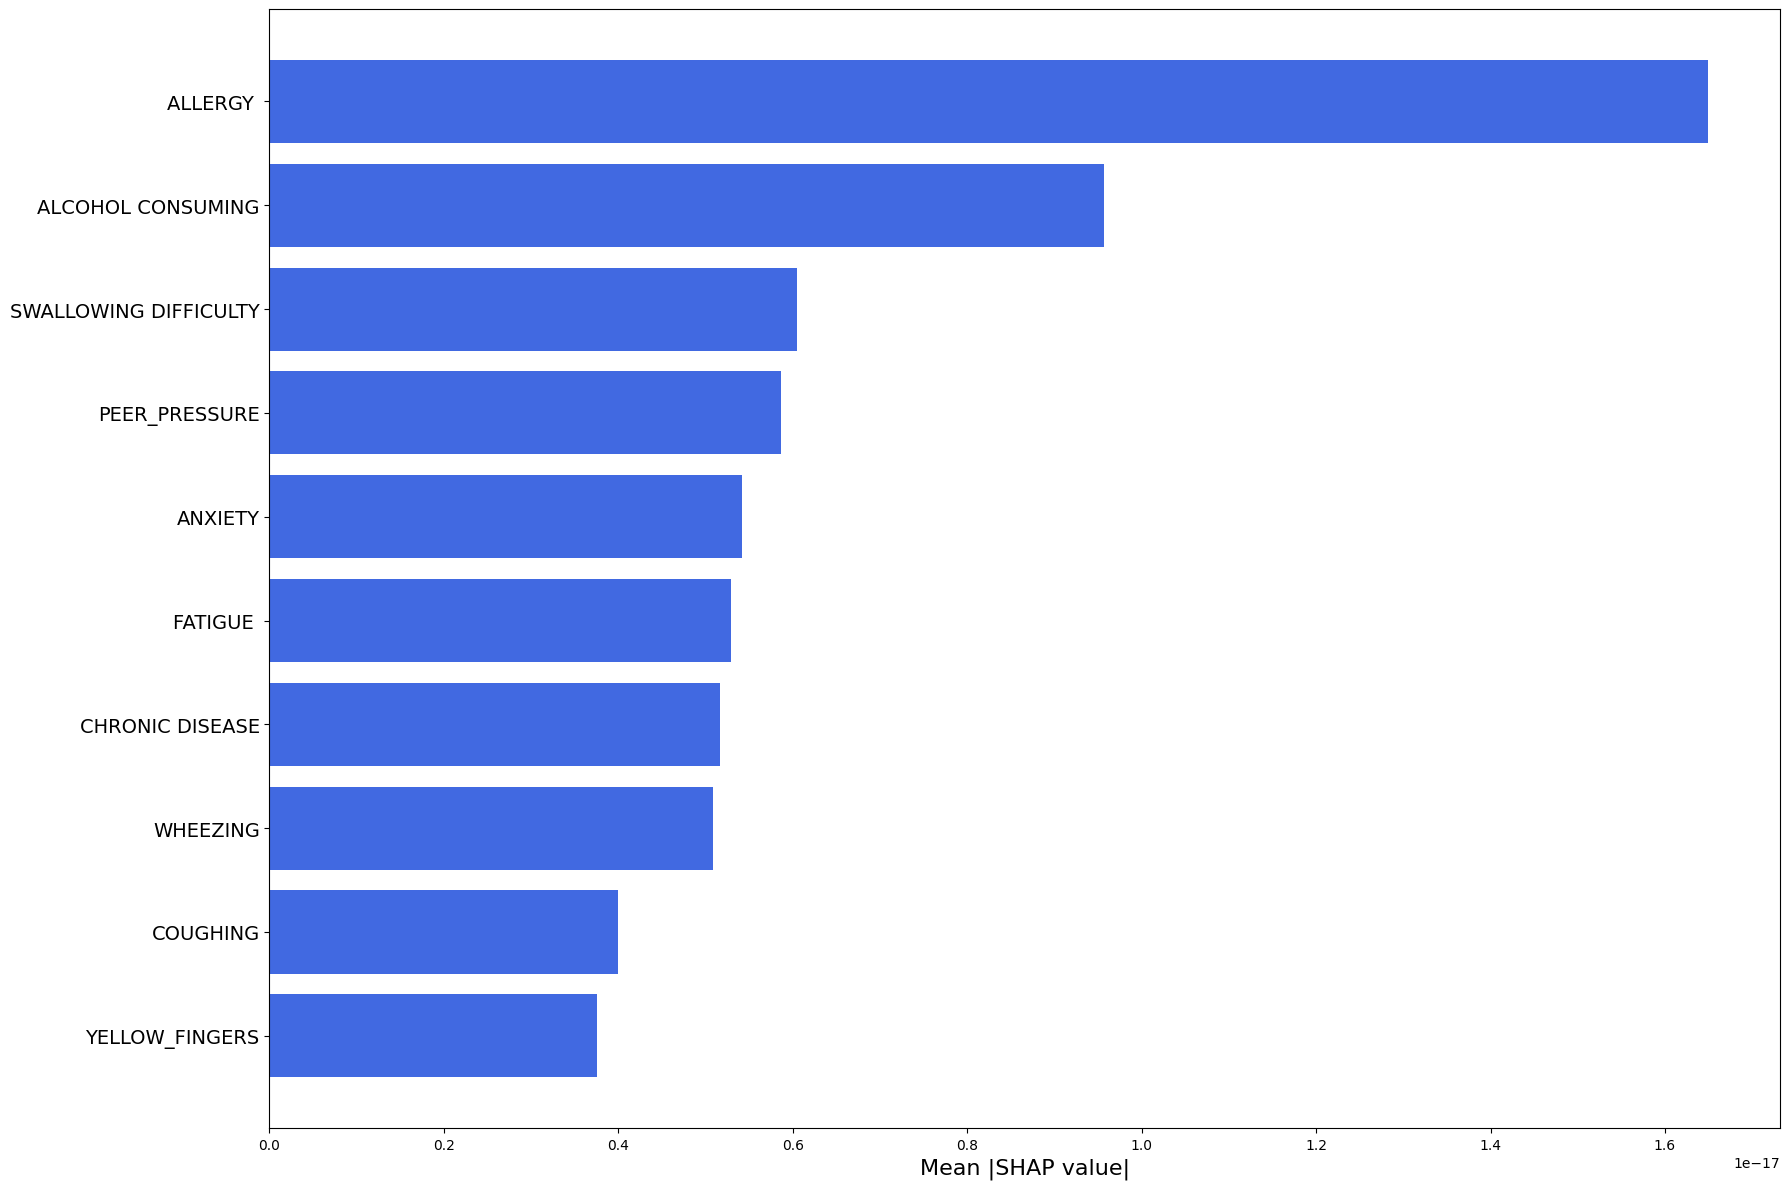

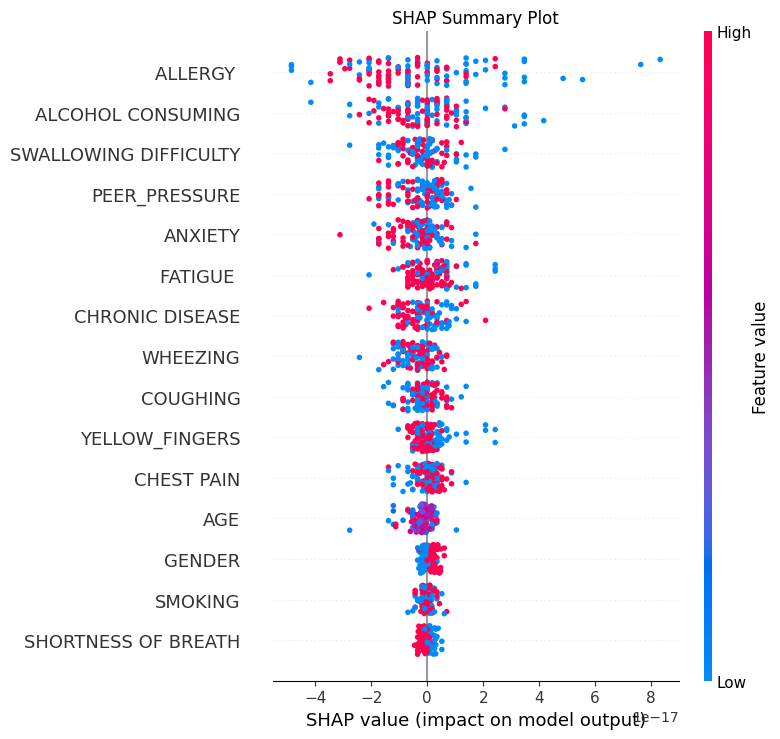

In [6]:

def create_comprehensive_shap_analysis(model, X_train, X_test, preprocessor=None, original_features=None):
    """
    Creates a comprehensive set of SHAP visualizations for model interpretation.
    Now handles feature names from the preprocessor.
    
    Parameters:
    -----------
    model : sklearn estimator
        Fitted model to analyze
    X_train : array-like
        Training data
    X_test : array-like
        Test data
    preprocessor : ColumnTransformer, optional
        Fitted preprocessor that was used to transform the data
    original_features : list, optional
        List of original feature names from the dataset
    """
    plt.style.use('default')
    
    # Ensure data is in the right format (dense array)
    X_test_dense = X_test.toarray() if hasattr(X_test, 'toarray') else np.array(X_test)
    
    # Get feature names from preprocessor if available
    if preprocessor is not None and original_features is not None:
        # Get numeric features
        numeric_features = [f for f in original_features 
                          if f in preprocessor.named_transformers_['num']
                          .get_feature_names_out().tolist()]
        
        # Get encoded categorical features
        
        feature_names = numeric_features 
    else:
        # Fallback to generic feature names
        feature_names = [f"Feature_{i}" for i in range(X_test_dense.shape[1])]
    
    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    try:
        # Calculate SHAP values
        shap_values = explainer.shap_values(X_test_dense)
        
        # Handle multi-class SHAP values
        if isinstance(shap_values, list):
            if len(shap_values) == 2:  # Binary classification
                shap_values = shap_values[1]
            else:  # Multi-class - take mean across classes
                shap_values = np.mean(shap_values, axis=0)
        
        # Handle 3D SHAP values
        if shap_values.ndim == 3:
            shap_values = np.mean(shap_values, axis=2)
        
        # Calculate mean absolute SHAP values
        mean_shap = np.abs(shap_values).mean(axis=0)
        
        # Create DataFrame with feature importance
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names[:len(mean_shap)],
            'Importance': mean_shap
        }).sort_values('Importance', ascending=True)
        
        # 1. Feature Importance Plot
        plt.figure(figsize=(18, 12))  # Adjusted figure size for better readability
        plt.barh(range(10), feature_importance_df.nlargest(10, 'Importance')['Importance'], color='royalblue')
        plt.yticks(range(10), feature_importance_df.nlargest(10, 'Importance')['Feature'], fontsize=14)
        plt.xlabel('Mean |SHAP value|', fontsize=16)
        plt.gca().invert_yaxis()  # Show the most important feature at the top
        plt.tight_layout()
        plt.show()


        # 2. SHAP Summary Plot
        plt.figure(figsize=(12, 8))
        if shap_values.ndim == 2:
            shap.summary_plot(
                shap_values,
                X_test_dense,
                feature_names=feature_names[:X_test_dense.shape[1]],
                show=False
            )
        plt.title('SHAP Summary Plot')
        plt.tight_layout()
        plt.show()
        plt.close()



        return {
            'shap_values': shap_values,
            'feature_importance': feature_importance_df,
            'explainer': explainer,
            'feature_names': feature_names
        }
    
    except Exception as e:
        print(f"Error in SHAP analysis: {str(e)}")
        print(f"Shape of X_test_dense: {X_test_dense.shape}")
        print(f"Number of feature names: {len(feature_names)}")
        raise

# Usage example:
# First create and fit the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=66,
    max_depth=25,
    min_samples_split=9,
    random_state=42
)
rf_model.fit(X_train_preprocessed, y_train)
joblib.dump(rf_model, "scaler.pkl")

# Then run the SHAP analysis with the preprocessor and original feature names
original_features = X.columns.tolist()  # Get original feature names from your dataset
results = create_comprehensive_shap_analysis(
    rf_model,
    X_train_preprocessed,
    X_test_preprocessed,
    preprocessor=preprocessor,
    original_features=original_features
)




In [7]:


# Display results for all random states and feature selection methods
for random_state, results in all_results.items():
    print(f"\nResults for random_state={random_state}:")
    for (method, model_name), accuracy in results.items():
        # Retrieve the corresponding model and data
        model = models[model_name]
        X_train_fs, X_test_fs = None, None
        if method == "SelectKBest":
            k_best_selector = SelectKBest(score_func=f_classif, k=10)
            X_train_fs = k_best_selector.fit_transform(preprocessor.fit_transform(X_train), y_train)
            X_test_fs = k_best_selector.transform(preprocessor.transform(X_test))
        elif method == "RFE":
            rfe_selector = RFE(estimator=RandomForestClassifier(random_state=random_state), n_features_to_select=10)
            X_train_fs = rfe_selector.fit_transform(preprocessor.fit_transform(X_train), y_train)
            X_test_fs = rfe_selector.transform(preprocessor.transform(X_test))

        # Train the model on the selected features
        model.fit(X_train_fs, y_train)
        y_pred = model.predict(X_test_fs)

        # Display accuracy
        print(f"  {method} - {model_name}: {accuracy * 100:.2f}%")

        # Display classification report
        print(classification_report(y_test, y_pred))



Results for random_state=42:
  SelectKBest - Random Forest: 91.94%
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        16
           1       0.95      0.94      0.95       108

    accuracy                           0.91       124
   macro avg       0.80      0.82      0.81       124
weighted avg       0.91      0.91      0.91       124

  SelectKBest - Gradient Boosting: 90.32%
              precision    recall  f1-score   support

           0       0.60      0.56      0.58        16
           1       0.94      0.94      0.94       108

    accuracy                           0.90       124
   macro avg       0.77      0.75      0.76       124
weighted avg       0.89      0.90      0.89       124



c:\Users\MARWAN\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


  SelectKBest - AdaBoost: 91.13%
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        16
           1       0.95      0.94      0.95       108

    accuracy                           0.91       124
   macro avg       0.80      0.82      0.81       124
weighted avg       0.91      0.91      0.91       124

  SelectKBest - Support Vector Machine: 91.94%
              precision    recall  f1-score   support

           0       0.69      0.56      0.62        16
           1       0.94      0.96      0.95       108

    accuracy                           0.91       124
   macro avg       0.81      0.76      0.79       124
weighted avg       0.91      0.91      0.91       124

  SelectKBest - Logistic Regression: 90.32%
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        16
           1       0.93      0.96      0.95       108

    accuracy                           0.90       124
   m

c:\Users\MARWAN\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


  RFE - AdaBoost: 90.32%
              precision    recall  f1-score   support

           0       0.82      0.56      0.67        16
           1       0.94      0.98      0.96       108

    accuracy                           0.93       124
   macro avg       0.88      0.77      0.81       124
weighted avg       0.92      0.93      0.92       124

  RFE - Support Vector Machine: 91.94%
              precision    recall  f1-score   support

           0       0.75      0.56      0.64        16
           1       0.94      0.97      0.95       108

    accuracy                           0.92       124
   macro avg       0.84      0.77      0.80       124
weighted avg       0.91      0.92      0.91       124

  RFE - Logistic Regression: 91.94%
              precision    recall  f1-score   support

           0       0.73      0.50      0.59        16
           1       0.93      0.97      0.95       108

    accuracy                           0.91       124
   macro avg       0.83     

In [8]:
import joblib  

best_model = model  # اختر النموذج الذي حقق أعلى دقة أو أقل خطأ
joblib.dump(best_model, "best_model.pkl")  # حفظ النموذج
print("Model expects", model.n_features_in_, "features")


Model expects 10 features


In [9]:
loaded_model = joblib.load("best_model.pkl")